In [ ]:
from pathlib import Path
import numpy as np
from typing import Any

from my_types import Vec3, Quat, ScalarBatch
from my_types import as_vec3
from io_csv import load_gyro_base, load_ref, load_acc, load_grav_ref, load_acc_lin_ref
from pipelines import integrate_gyro_acc_no_gate, integrate_gyro_acc_with_gate_acc, integrate_gyro_acc_with_gate_gyro_acc
from evaluation import calc_angle_err, print_err_status, save_err_csv, plot_err_from_csv, save_estimated_vec3_csv
from evaluation import plot_err_colored_by_weights, evaluate_estimated_vec3_autosign
from autotune import auto_param_exp2_1, auto_param_exp2_2, auto_param_exp2_3

EPS: float = 1e-9

In [2]:
root: Path = Path.cwd().parent
run_dir: Path = root / "data" / "21:08_oct_07_2025_5min"
#run_dir: Path = root / "data" / "21:23_oct_07_2025_9min"

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"
grav_path: Path = run_dir / "Gravity.csv"
acc_path: Path = run_dir / "AccelerometerUncalibrated.csv"
acc_lin_path: Path = run_dir / "Accelerometer.csv"

for p in [ori_path, gyro_path, grav_path, acc_path, acc_lin_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

In [3]:
t_src_gyro, w_src_gyro, dt, t_new, w_avg_gyro = load_gyro_base(gyro_path)

q_ref_interp = load_ref(ori_path, t_new)
q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

a_src_interp = load_acc(acc_path, t_new)

dt = dt[1000:]
t_new = t_new[1000:]
w_avg_gyro = w_avg_gyro[1000:]
q_ref_interp = q_ref_interp[1000:]
a_src_interp = a_src_interp[1000:]

In [4]:
## exp1: without any gating

q0: Quat = q_ref_interp[0].copy()
g0: float = 9.80665
g_world_unit: Vec3 = as_vec3(np.array([0, 0, -1]))

param, diag, still_mask = auto_param_exp2_1(q0=q0, w=w_avg_gyro, dt=dt, a=a_src_interp,
                                                g0=g0, g_world_unit=g_world_unit,
                                                min_duration_s=0.5, smooth_win=5,
                                                w_thr=None, a_thr=None,
                                                tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3, 4, 5))

print("[choosen param]")
for i in param:
        print(i, ":", param[i])
print("")
print("[top 3 tau candidates]")
for i in diag["tau_table_top3"]:
        print("tau:", i["tau"], ", K:", i["K"], ", still_score_mean_angle(rad):", i["still_score_mean_angle(rad)"])
print("")

K: float = param["K"]

q_gyro_acc_1, g_body_est_1, a_lin_est_1 = integrate_gyro_acc_no_gate(q0, w_avg_gyro, dt,
                                                       K, g0, g_world_unit,
                                                       a_src_interp)

angle_err_gyro_acc_1: ScalarBatch = calc_angle_err(q_gyro_acc_1, q_ref_interp)
print_err_status("Gyro+Acc", angle_err_gyro_acc_1)

[choosen param]
K : 0.006665852864585986
acc_gate_sigma : inf
gyro_gate_sigma : inf
tau : 1.5
best_run : (11086, 11288, 202)

[top 3 tau candidates]
tau: 1.5 , K: 0.006665852864585986 , still_score_mean_angle(rad): 0.009317589603125634
tau: 2.0 , K: 0.0049993896484394895 , still_score_mean_angle(rad): 0.009710388107931723
tau: 1.0 , K: 0.009998779296878979 , still_score_mean_angle(rad): 0.00977671731801268

Gyro+Acc angle error in rad — min/max/mean
0.0029631487606160563 1.4153801561692254 0.3514525852688601

Gyro+Acc angle error in deg — min/max/mean
0.16977591805272071 81.09530935506396 20.136749834867373


In [5]:
# exp 2-2: Gyro+Acc+Gating(Acc)

q0: Quat = q_ref_interp[0].copy()
g0: float = 9.80665
g_world_unit: Vec3 = as_vec3(np.array([0, 0, -1]))

param, diag, still_mask = auto_param_exp2_2(q0=q0, w=w_avg_gyro, dt=dt, a=a_src_interp,
                                                g0=g0, g_world_unit=g_world_unit,
                                                p_acc=90, sigma_floor=1e-3,
                                                min_duration_s=0.5, smooth_win=5,
                                                w_thr=None, a_thr=None,
                                                tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3))

print("[choosen param]")
for i in param:
        print(i, ":", param[i])
print("")
print("[top 3 tau candidates]")
for i in diag["tau_table_top3"]:
        print("tau:", i["tau"], ", K:", i["K"], ", still_score_mean_angle(rad):", i["still_score_mean_angle(rad)"])
print("")

K: float = param["K"]

best = None
best_mean: float = np.inf
acc_gate_sigma_base: float = param["acc_gate_sigma"]
for s in (1, 3, 5, 10, 50, 100, 1000000): # np.inf
        if np.isinf(s):
                acc_gate_sigma = np.inf
        else:
                acc_gate_sigma = acc_gate_sigma_base * s
        q, g_body_est, a_lin_est, weight_acc = integrate_gyro_acc_with_gate_acc(
                                                                        q0, w_avg_gyro, dt,
                                                                        K, g0, g_world_unit,
                                                                        acc_gate_sigma, a_src_interp)

        angle_err: ScalarBatch = calc_angle_err(q, q_ref_interp)
        mean_err: float = float(np.mean(angle_err))

        print(f"[s={s}] acc_gate_sigma={acc_gate_sigma:.7f} | "
                f"mean_weight_acc={float(np.mean(weight_acc)):.7f} | "
                f"mean_err(rad)={mean_err:.7f}")

        if mean_err < best_mean:
                best_mean = mean_err
                best = (s, acc_gate_sigma, q, g_body_est, a_lin_est, weight_acc, angle_err)

best_s, best_sigma, q_gyro_acc_2, g_body_est_2, a_lin_est_2, weight_acc_2, angle_err_gyro_acc_2 = best
print("")
print(f"[best] s={best_s}, acc_gate_sigma={best_sigma:.7f}, mean_err(rad)={best_mean:.7f}")
print("")
print_err_status("Gyro+Acc+Gating(Acc)", angle_err_gyro_acc_2)

[choosen param]
K : 0.006665852864585986
acc_gate_sigma : 0.5311068818838554
gyro_gate_sigma : inf
tau : 1.5
best_run : (11086, 11288, 202)

[top 3 tau candidates]
tau: 1.5 , K: 0.006665852864585986 , still_score_mean_angle(rad): 0.009317589603125634
tau: 2.0 , K: 0.0049993896484394895 , still_score_mean_angle(rad): 0.009710388107931723
tau: 1.0 , K: 0.009998779296878979 , still_score_mean_angle(rad): 0.00977671731801268

[s=1] acc_gate_sigma=0.5311069 | mean_weight_acc=0.1930711 | mean_err(rad)=0.3388874
[s=3] acc_gate_sigma=1.5933206 | mean_weight_acc=0.5327112 | mean_err(rad)=0.3434505
[s=5] acc_gate_sigma=2.6555344 | mean_weight_acc=0.7314294 | mean_err(rad)=0.3452435
[s=10] acc_gate_sigma=5.3110688 | mean_weight_acc=0.9030093 | mean_err(rad)=0.3471815
[s=50] acc_gate_sigma=26.5553441 | mean_weight_acc=0.9950744 | mean_err(rad)=0.3511321
[s=100] acc_gate_sigma=53.1106882 | mean_weight_acc=0.9987550 | mean_err(rad)=0.3513703
[s=1000000] acc_gate_sigma=531106.8818839 | mean_weight_ac

In [6]:
# exp 2-3: Gyro+Acc+Gating(Gyro/Acc)

q0: Quat = q_ref_interp[0].copy()
g0: float = 9.80665
g_world_unit: Vec3 = as_vec3(np.array([0, 0, -1]))

param, diag, still_mask = auto_param_exp2_3(q0=q0, w=w_avg_gyro, dt=dt, a=a_src_interp,
                                                g0=g0, g_world_unit=g_world_unit,
                                                p_gyro=90, p_acc=90, sigma_floor=1e-3,
                                                min_duration_s=0.5, smooth_win=5,
                                                w_thr=None, a_thr=None,
                                                tau_candidates=(0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3))

print("[choosen param]")
for i in param:
        print(i, ":", param[i])
print("")
print("[top 3 tau candidates]")
for i in diag["tau_table_top3"]:
        print("tau:", i["tau"], ", K:", i["K"], ", still_score_mean_angle(rad):", i["still_score_mean_angle(rad)"])
print("")

K = param["K"]
best = None
best_mean: float = np.inf
acc_gate_sigma_base: float = param["acc_gate_sigma"]
for sa in (1, 3, 5, 10, 50, 100, 1000000): # np.inf
        if np.isinf(sa):
                acc_gate_sigma = np.inf
        else:
                acc_gate_sigma = acc_gate_sigma_base * sa
        q, g_body_est, a_lin_est, weight_acc, weight_gyro = integrate_gyro_acc_with_gate_gyro_acc(
                                                                q0, w_avg_gyro, dt,
                                                                K, g0, g_world_unit,
                                                                acc_gate_sigma, np.inf, a_src_interp)

        angle_err: ScalarBatch = calc_angle_err(q, q_ref_interp)
        mean_err: float = float(np.mean(angle_err))

        print(f"[sa={sa}] acc_gate_sigma={acc_gate_sigma:.7f} | "
              f"mean_weight_acc={float(np.mean(weight_acc)):.7f} | "
              f"mean_err(rad)={mean_err:.7f}")

        if mean_err < best_mean:
                best_mean = mean_err
                best = (sa, acc_gate_sigma, q, g_body_est, a_lin_est, weight_acc, weight_gyro, angle_err)

best_sa, best_acc_sigma, q_gyro_acc_3, g_body_est_3, a_lin_est_3, weight_acc_3, wieght_gyro_3, angle_err_gyro_acc_3 = best
print("")

best=None
best_mean = np.inf
gyro_gate_sigma_base: float = param["gyro_gate_sigma"]
for sg in (1, 3, 5, 10, 50, 100, 1000000): # np.inf
        if np.isinf(sg):
                gyro_gate_sigma = np.inf
        else:
                gyro_gate_sigma = gyro_gate_sigma_base * sg
 
        q, g_body_est, a_lin_est, weight_acc, weight_gyro = integrate_gyro_acc_with_gate_gyro_acc(
                                                                q0, w_avg_gyro, dt,
                                                                K, g0, g_world_unit,
                                                                best_acc_sigma, gyro_gate_sigma, a_src_interp)

        angle_err: ScalarBatch = calc_angle_err(q, q_ref_interp)
        mean_err: float = float(np.mean(angle_err))

        print(f"[sa={best_sa}] acc_gate_sigma={best_acc_sigma:.7f} | "
              f"[sg={sg}] gyro_gate_sigma={gyro_gate_sigma:.7f} | "
              f"mean_weight_gyro={float(np.mean(weight_gyro)):.7f} | "
              f"mean_err(rad)={mean_err:.7f}")

        if mean_err < best_mean:
                best_mean = mean_err
                best = (sg, gyro_gate_sigma, q, g_body_est, a_lin_est, weight_acc, weight_gyro, angle_err)

best_sg, best_gyro_sigma, q_gyro_acc_3, g_body_est_3, a_lin_est_3, weight_acc_3, weight_gyro_3, angle_err_gyro_acc_3 = best

print("")
print(f"[best] sa={best_sa}, acc_gate_sigma={best_acc_sigma:.7f}, sg={best_sg}, gyro_gate_sigma={best_gyro_sigma}, mean_err(rad)={best_mean:.7f}")
print("")
print_err_status("Gyro+Acc+Gating(Gyro/Acc)", angle_err_gyro_acc_3)

[choosen param]
K : 0.014283970424112828
acc_gate_sigma : 0.5311068818838554
gyro_gate_sigma : 0.7454291381432401
tau : 0.7
best_run : (11086, 11288, 202)

[top 3 tau candidates]
tau: 0.7 , K: 0.014283970424112828 , still_score_mean_angle(rad): 0.007585362489563273
tau: 1.0 , K: 0.009998779296878979 , still_score_mean_angle(rad): 0.007760548063826287
tau: 0.5 , K: 0.019997558593757958 , still_score_mean_angle(rad): 0.008430662411097765

[sa=1] acc_gate_sigma=0.5311069 | mean_weight_acc=0.1930711 | mean_err(rad)=0.3418014
[sa=3] acc_gate_sigma=1.5933206 | mean_weight_acc=0.5327112 | mean_err(rad)=0.3550959
[sa=5] acc_gate_sigma=2.6555344 | mean_weight_acc=0.7314294 | mean_err(rad)=0.3611950
[sa=10] acc_gate_sigma=5.3110688 | mean_weight_acc=0.9030093 | mean_err(rad)=0.3745642
[sa=50] acc_gate_sigma=26.5553441 | mean_weight_acc=0.9950744 | mean_err(rad)=0.3937066
[sa=100] acc_gate_sigma=53.1106882 | mean_weight_acc=0.9987550 | mean_err(rad)=0.3947187
[sa=1000000] acc_gate_sigma=531106.88

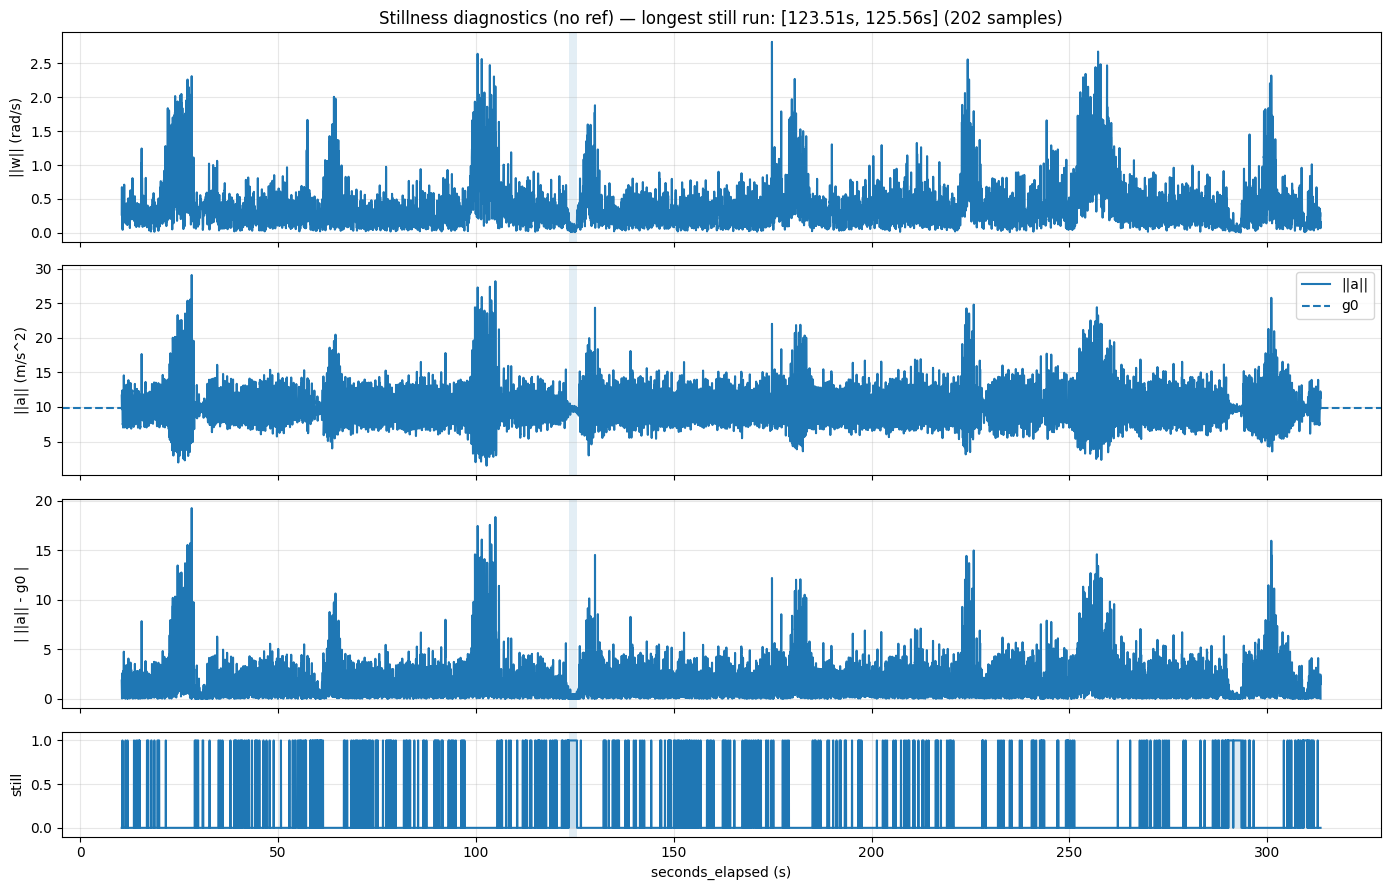

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_still_diagnostics(
    t,
    w_avg_gyro,
    a_src,
    still_mask,
    g0=9.80665,
    still_run=None,          # (start, end, len) or None
    title="Stillness diagnostics (no ref)"
):
    """
    Plots:
      1) gyro norm ||w||
      2) accel norm ||a|| and g0
      3) accel residual | ||a|| - g0 |
      4) still mask (0/1)

    Also highlights the longest still run if provided.
    """
    t = np.asarray(t).reshape(-1)
    w = np.asarray(w_avg_gyro)
    a = np.asarray(a_src)
    still = np.asarray(still_mask).astype(bool)

    wn = np.linalg.norm(w, axis=1)
    an = np.linalg.norm(a, axis=1)
    acc_resid = np.abs(an - g0)

    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(14, 9), height_ratios=[2, 2, 2, 1])

    # 1) gyro norm
    axs[0].plot(t, wn)
    axs[0].set_ylabel("||w|| (rad/s)")
    axs[0].grid(True, alpha=0.3)

    # 2) accel norm
    axs[1].plot(t, an, label="||a||")
    axs[1].axhline(g0, linestyle="--", label="g0")
    axs[1].set_ylabel("||a|| (m/s^2)")
    axs[1].grid(True, alpha=0.3)
    axs[1].legend()

    # 3) accel residual
    axs[2].plot(t, acc_resid)
    axs[2].set_ylabel("| ||a|| - g0 |")
    axs[2].grid(True, alpha=0.3)

    # 4) still mask
    axs[3].plot(t, still.astype(int))
    axs[3].set_ylabel("still")
    axs[3].set_ylim(-0.1, 1.1)
    axs[3].grid(True, alpha=0.3)
    axs[3].set_xlabel("seconds_elapsed (s)")

    # shade all still regions lightly
    # (simple approach: shade where still==True using fill_between)
    axs[3].fill_between(t, 0, 1, where=still, alpha=0.15, step="pre")

    # highlight longest run if provided
    if still_run is not None:
        s, e, _ = still_run
        t0, t1 = t[s], t[e-1]
        for ax in axs:
            ax.axvspan(t0, t1, alpha=0.12)
        axs[0].set_title(f"{title} — longest still run: [{t0:.2f}s, {t1:.2f}s] ({e-s} samples)")
    else:
        axs[0].set_title(f"{title} — no still run found")

    plt.tight_layout()
    plt.show()

plot_still_diagnostics(t_new, w_avg_gyro, a_src_interp, still_mask, g0=9.80665, still_run=param["best_run"])

In [8]:
out_dir: Path = root / "output"
out_dir.mkdir(parents=True, exist_ok=True)
out_path_1: Path = out_dir / "02_exp2-1_angle_err_gyro_acc.csv"
out_path_2: Path = out_dir / "02_exp2-2_angle_err_gyro_acc.csv"
out_path_3: Path = out_dir / "02_exp2-3_angle_err_gyro_acc.csv"
save_err_csv(out_path_1, t_new, angle_err_gyro_acc_1)
save_err_csv(out_path_2, t_new, angle_err_gyro_acc_2)
save_err_csv(out_path_3, t_new, angle_err_gyro_acc_3)

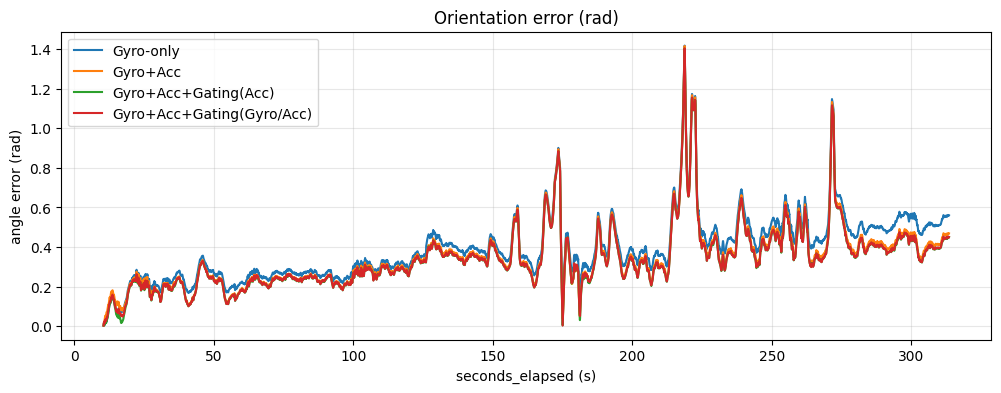

In [9]:
out_gyro_path = out_dir / "01_angle_err_gyro.csv"

plot_err_from_csv([
        ("Gyro-only", out_gyro_path),
        ("Gyro+Acc", out_path_1),
        ("Gyro+Acc+Gating(Acc)", out_path_2),
        ("Gyro+Acc+Gating(Gyro/Acc)", out_path_3)
])

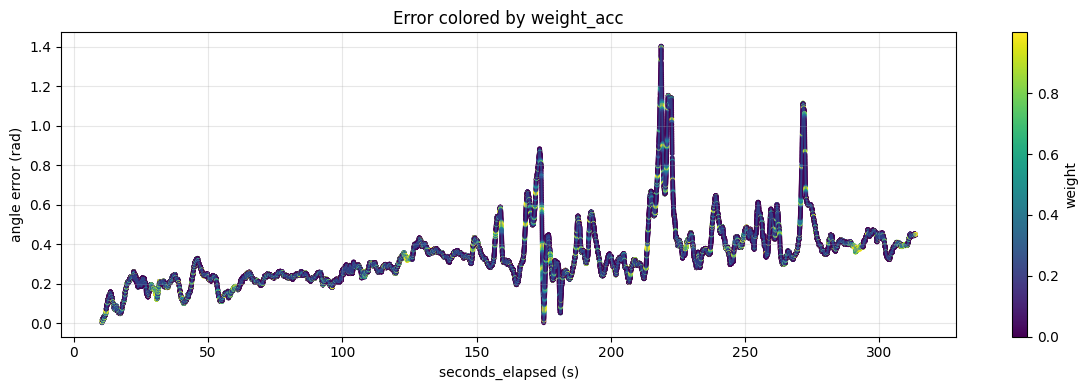

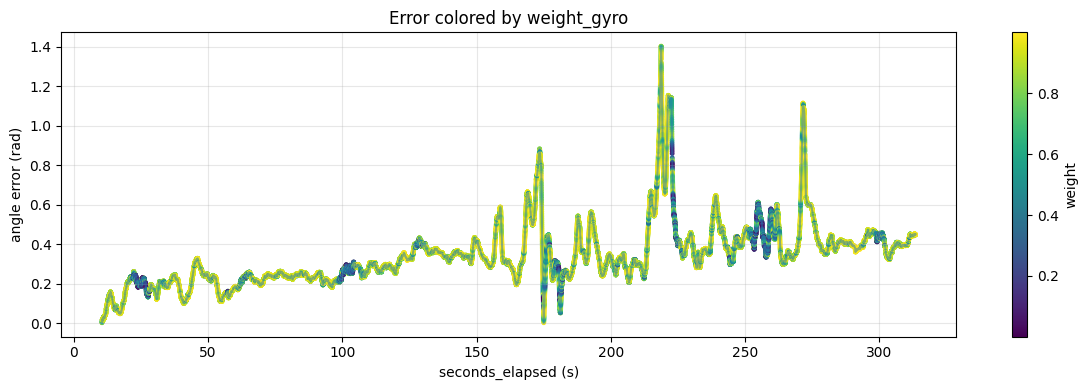

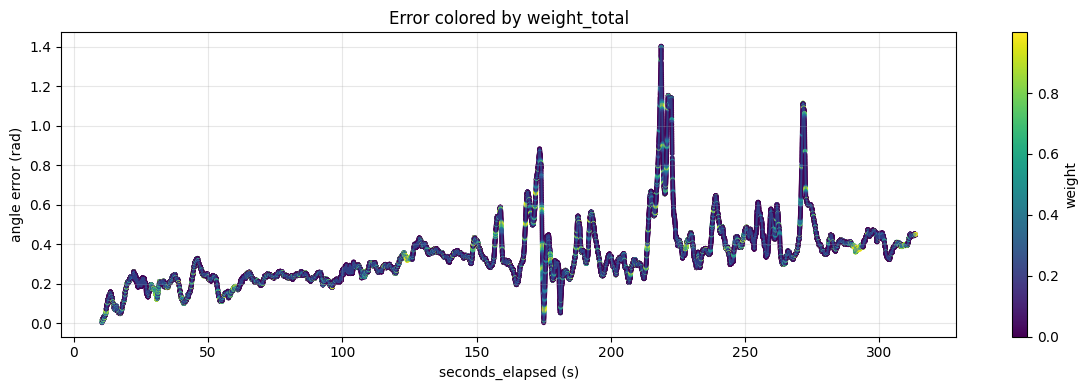

In [10]:
plot_err_colored_by_weights(t_new, angle_err_gyro_acc_3, weight_acc_3, "weight_acc")
plot_err_colored_by_weights(t_new, angle_err_gyro_acc_3, weight_gyro_3, "weight_gyro")
plot_err_colored_by_weights(t_new, angle_err_gyro_acc_3, weight_acc_3 * weight_gyro_3, "weight_total")

In [11]:
#est_dir: Path = root / "estimate"
#est_dir.mkdir(parents=True, exist_ok=True)

#print("Gravity:")
#g_ref_interp = load_grav_ref(grav_path, t_new)
#g_est_sign_fixed, g_rmse_norm = evaluate_estimated_vec3_autosign(g_body_est, g_ref_interp)
#print("")

#print("Linear Acc:")
#a_lin_ref_interp = load_acc_lin_ref(acc_lin_path, t_new)
#a_lin_est_sign_fixed, a_lin_rmse_norm = evaluate_estimated_vec3_autosign(a_lin_est, a_lin_ref_interp)
#print("")

#save_estimated_vec3_csv(est_dir / "03_gravity_estimated.csv", t_new, g_est_sign_fixed)
#save_estimated_vec3_csv(est_dir / "03_linear_acc_estimated.csv", t_new, a_lin_est_sign_fixed)

#print("consistency ratio (a_lin / g):", a_lin_rmse_norm / max(g_rmse_norm, EPS))

In [12]:
#import numpy as np

#def unit(v):
#    n = np.linalg.norm(v, axis=1, keepdims=True)
#    return v / np.maximum(n, 1e-12)

#def gravity_direction_angle_err(g_est: np.ndarray, g_ref: np.ndarray):
#    ge = unit(g_est)
#    gr = unit(g_ref)
#    c = np.sum(ge * gr, axis=1)
#    c = np.clip(c, -1.0, 1.0)
#    ang = np.arccos(c)  # rad
#    print("gravity dir angle err (rad): min/max/mean",
#          float(ang.min()), float(ang.max()), float(ang.mean()))
#    print("gravity dir angle err (deg): min/max/mean",
#          float(np.rad2deg(ang.min())), float(np.rad2deg(ang.max())), float(np.rad2deg(ang.mean())))
#    return ang

#def accel_gravity_alignment(a_src: np.ndarray, g_est: np.ndarray, g0: float, thr: float = 0.3):
#    a_norm = np.linalg.norm(a_src, axis=1)
#    mask = np.abs(a_norm - g0) < thr

#    au = unit(a_src)
#    gu = unit(g_est)
#    dot = np.sum(au * gu, axis=1)  # 부호는 플랫폼 정의에 따라 +/-1이 목표

#    d = dot[mask]
#    print(f"stationary mask count: {int(mask.sum())}/{len(mask)}")
#    print("dot(a_unit, g_unit) on stationary: mean/min/max",
#          float(np.mean(d)), float(np.min(d)), float(np.max(d)))
#    return dot, mask

#gravity_direction_angle_err(g_est_sign_fixed, g_ref_interp)
#print("=============")
#accel_gravity_alignment(a_src_interp, g_est_sign_fixed, g0)
#print("=============")